# Neurosymbolic Software Tutorial - Discrete

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/tutorial2_discrete.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline

- TODO

In [2]:
%load_ext autoreload
%autoreload 2

import neurosym as ns
import numpy as np

## Part 1: Arithmetic DSL

We would like to be able to define arithmetic functions, of various types.

### Exercise 1A: Create a DSL

We would like our DSL to be able to represent the following functions. For future experiments, make sure you don't include cosine.

- $f_0(x) = x + 1$
- $f_1(x) = x^2 + \frac{x}{\sin x}$
- $f_2(x) = (x + 2)^x$
- $f_3(x) = \begin{cases}
x^2 & x < 0\\
\sqrt x & x \geq 0\\
\end{cases}$

In [3]:
dslf = ns.DSLFactory()
dslf.concrete("0", "() -> f", lambda: 0)
dslf.concrete("1", "() -> f", lambda: 1)
dslf.concrete("2", "() -> f", lambda: 2)
dslf.concrete("+", "(f, f) -> f", lambda x, y: x + y)
dslf.concrete("-", "(f, f) -> f", lambda x, y: x - y)
# BEGIN SOLUTION "YOUR CODE HERE"
dslf.concrete("*", "(f, f) -> f", lambda x, y: x * y)
dslf.concrete("**", "(f, f) -> f", lambda x, y: x ** y)
dslf.concrete("/", "(f, f) -> f", lambda x, y: x / y)
dslf.concrete("sin", "f -> f", np.sin)
dslf.concrete("sqrt", "f -> f", np.sqrt)
dslf.concrete("<", "(f, f) -> b", lambda x, y: x < y)
dslf.concrete("ite", "(b, f, f) -> f", lambda cond, x, y: x if cond else y)
# END SOLUTION
dslf.lambdas()
dslf.prune_to("f -> f")
dsl = dslf.finalize()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [4]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
              + :: (f, f) -> f
              - :: (f, f) -> f
              * :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
           sqrt :: f -> f
              < :: (f, f) -> b
            ite :: (b, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


### Exercise 1B: Write your functions

We have provided $f_0$, it is up to you to write $f_1$ through $f_3$. Note that there are no leaf nodes in the neurosym DSLs, so terminal productions are represented as s-expressions with no children. Run the tests in the following cell to make sure your DSL and programs are working properly

In [5]:
f_0 = "(lam (+ ($0_0) (1)))"
# BEGIN SOLUTION "YOUR CODE HERE"
f_1 = "(lam (+ (** ($0_0) (2)) (/ ($0_0) (sin ($0_0)))))"
f_2 = "(lam (** (+ ($0_0) (2)) ($0_0)))"
f_3 = "(lam (ite (< ($0_0) (0)) (** ($0_0) (2)) (sqrt ($0_0))))"
# END SOLUTION

In [6]:
dist_family = ns.BigramProgramDistributionFamily(dsl)
uniform = dist_family.uniform()

In [24]:
cos2 = "(lam (- (1) (** (sin ($0_0)) (2))))"
cos = "(lam (sqrt (- (1) (** (sin ($0_0)) (2)))))"

In [25]:
dist_family.compute_likelihood(uniform, ns.parse_s_expression(cos2))

-14.90944

In [26]:
dist_family.compute_likelihood(uniform, ns.parse_s_expression(cos))

-17.394346

In [27]:
1 / np.exp(dist_family.compute_likelihood(uniform, ns.parse_s_expression(cos2))) / 1e6

2.9859842593202814

In [28]:
1/np.exp(-15) / 1e6

3.2690173724721108

In [29]:
dist_family._arities

array([1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 3, 1, 1, 1])

In [30]:
dist_family._valid_mask.shape

(15, 3, 15)

In [31]:
%prun vals = [(ns.render_s_expression(x), like) for x, like in dist_family.enumerate(uniform, min_likelihood=-15)]
# %time [dist_family.sample(uniform, np.random.RandomState(seed)) for seed in range(100)]
len(vals)

KeyboardInterrupt: 

In [22]:
[x for x, _ in vals if x == cos2]

['(lam (- (1) (** (sin ($0_0)) (2))))']

In [19]:
for x, like in dist_family.enumerate(uniform, min_likelihood=-10):
    print("*" * 10, ns.render_s_expression(x), like)

   <root> 0 -1.278 f -> f
   lam 0 -1.278 f
   <root> 0 -2.556 f -> f
   lam 0 -2.556 f
     * 0 -0.07109332656860357 f
     ** 0 -0.07109332656860357 f
     + 0 -0.07109332656860357 f
     - 0 -0.07109332656860357 f
     / 0 -0.07109332656860357 f
       ite 0 -0.07109332656860357 b
     < 0 -0.07109332656860357 f
   sin 0 -0.07109332656860357 f
   sqrt 0 -0.07109332656860357 f
********** (lam ($0_0)) -2.4849066734313965
********** (lam (0)) -2.4849066734313965
********** (lam (1)) -2.4849066734313965
********** (lam (2)) -2.4849066734313965
   <root> 0 -3.834 f -> f
   lam 0 -3.834 f
     * 0 -1.3490933265686036 f
     ** 0 -1.3490933265686036 f
     + 0 -1.3490933265686036 f
     - 0 -1.3490933265686036 f
     / 0 -1.3490933265686036 f
       ite 0 -1.3490933265686036 b
     < 0 -1.3490933265686036 f
   sin 0 -1.3490933265686036 f
   sqrt 0 -1.3490933265686036 f
   <root> 0 -5.112 f -> f
   lam 0 -5.112 f
     * 0 -2.6270933265686036 f
     * 0 -0.14218665313720713 f
     ** 0 -0.14

In [139]:
def test_program(actual_program, expected_fn):
    actual_fn = dsl.compute(dsl.initialize(ns.parse_s_expression(actual_program)))
    inputs = np.linspace(-1, 1, 100)
    actual = np.array([actual_fn(x) for x in inputs])
    expected = np.array([expected_fn(x) for x in inputs])
    delta = np.abs(actual - expected)
    bad = delta > 1e-5
    if (~bad).all():
        return
    [[bad_input, *_]] = np.where(bad)
    raise AssertionError(f"On input {inputs[bad_input]}, expected {expected[bad_input]} but recvd {actual[bad_input]}")

test_program(f_0, lambda x: x + 1)
test_program(f_1, lambda x: x ** 2 + x / np.sin(x))
test_program(f_2, lambda x: (x + 2) ** x)
test_program(f_3, lambda x: x ** 2 if x < 0 else x ** 0.5)

## Part 3: Program Generation

We're going to use neural guided search to search for the program in the DSL that maximally fits the dataset.

- Cell 1: Define a pytorch dataset from the saved data.
- Cell 2: Define `neural_dsl`. This DSL extend the DSL we created with _neural modules_.
- Cell 3: Define optimization functions to train module parameters.
- Cell 4: Define a stopping condition for the search.
- Cell 5: Define the search space and initiate the search.

In [140]:
from neurosym.datasets.load_data import DatasetFromNpy, DatasetWrapper

def dataset_factory(train_seed):
    return DatasetWrapper(
        DatasetFromNpy(
            "../data/regression_example/train_ex_data.npy",
            "../data/regression_example/train_ex_labels.npy",
            train_seed,
        ),
        DatasetFromNpy(
            "../data/regression_example/test_ex_data.npy",
            "../data/regression_example/test_ex_labels.npy",
            None,
        ),
        batch_size=200,
    )


datamodule = dataset_factory(42)
input_dim, output_dim = datamodule.train.get_io_dims()
if IS_REGRESSION:
    output_dim = 1
print(input_dim, output_dim)

NameError: name 'IS_REGRESSION' is not defined

In [15]:
import neurosym as ns
from neurosym.examples import near

t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
t.typedef("fO", "{f, $O}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    modules={
        **near.create_modules(
            "mlp",
            [t("($fL) -> $fL"), t("($fL) -> $fO")],
            near.mlp_factory(hidden_size=10),
        ),
        **near.create_modules(
            "rnn_seq2seq",
            [t("([$fL]) -> [$fL]"), t("([$fL]) -> [$fO]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    },
)


In [16]:
import pytorch_lightning as pl
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

trainer_cfg = near.NEARTrainerConfig(
    lr=1e-3,
    max_seq_len=100,
    n_epochs=30,
    num_labels=output_dim,
    train_steps=len(datamodule.train),
    loss_fn='MSELossRegression',
    scheduler='cosine',
    optimizer='adam',
)

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min"
)
def validation_cost(node):
    trainer = pl.Trainer(
        max_epochs=trainer_cfg.n_epochs,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False,
        enable_model_summary=False,
        enable_progress_bar=False,
        logger=False,
        callbacks=[early_stop_callback],
    )
    try:
        initialized_p = neural_dsl.initialize(node.program)
    except near.PartialProgramNotFoundError:
        return 10000.

    model = neural_dsl.compute(initialized_p)
    if not isinstance(model, torch.nn.Module):
        del model
        del initialized_p
        model = near.TorchProgramModule(dsl=neural_dsl, program=node.program)
    pl_model = near.NEARTrainer(model, config=trainer_cfg)
    trainer.fit(
        pl_model, datamodule.train_dataloader(), datamodule.val_dataloader()
    )
    return trainer.callback_metrics["val_loss"].item()


In [17]:
def checker(node):
    """
    In NEAR, any program that has no holes is valid.
    The hole checking is done before this function will
    be called so we can assume that the program has no holes.
    """
    return (
        set(ns.symbols_for_program(node.program)) - set(dsl.symbols())
        == set()
    )

In [18]:
g = near.near_graph(
    neural_dsl,
    ns.parse_type(
        s="([{f, $L}]) -> [{f, $O}]", env=ns.TypeDefiner(L=input_dim, O=output_dim)
    ),
    is_goal=checker,
)

iterator = ns.search.bounded_astar(g, validation_cost, max_depth=7)
best_program_nodes = []
# Let's collect the top four programs
while len(best_program_nodes) <= 3:
    try:
        node = next(iterator)
        cost = validation_cost(node)
        best_program_nodes.append((node, cost))
    except StopIteration:
        print("No more programs found.")
        break

No more programs found.


## Part 4: Program Inspection

A key benifit of program synthesis is that the output program is interpretable.

- Cell 1: Render the best program.
- Cell 2: Visualize the output space of the best program.
    - Exersise: Does the program discovered line up with your initial hypotheses?

(0) Cost: 0.1548, (output (map (linear)))
(1) Cost: 0.1674, (output (map (ite (linear_bool) (linear) (linear))))
(2) Cost: 0.1751, (output (map (ite (sum) (linear) (linear))))
(output (map (linear)))


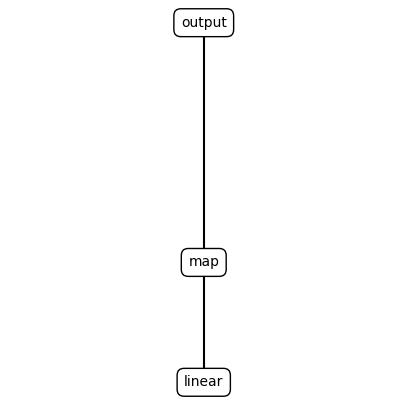

In [19]:
def plot_expression(sexpr, x=0.5, y=1, level=1, dx=0.1, ax=None, text_offset=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_axis_off()

    ax.text(x, y, sexpr.symbol, ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    num_children = len(sexpr.children)
    if num_children > 0:
        child_y = y - 1 / level
        for i, child in enumerate(sexpr.children):
            child_x = x - (dx * (num_children - 1) / 2) + i * dx
            ax.plot([x, child_x], [y - text_offset, child_y + text_offset], 'k-')
            plot_expression(child, x=child_x, y=child_y, level=level + 1, dx=dx / 2, ax=ax, text_offset=text_offset)

    if ax is None:
        plt.show()

best_program_nodes = sorted(best_program_nodes, key=lambda x: x[1])
for i, (node, cost) in enumerate(best_program_nodes):
    print("({i}) Cost: {cost:.4f}, {program}".format(i=i, program=ns.render_s_expression(node.program), cost=cost))

best_program_node = best_program_nodes[0]
print(ns.render_s_expression(best_program_node[0].program))
plot_expression(best_program_node[0].program)


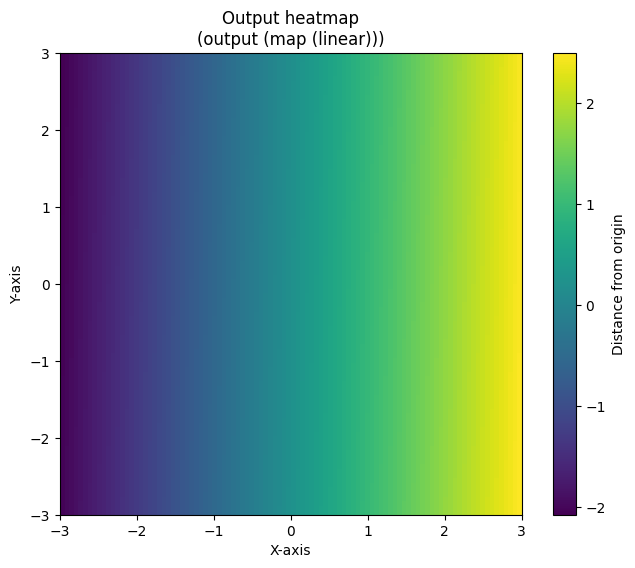

In [20]:
best_program_node = best_program_nodes[0]
module = near.TorchProgramModule(dsl=neural_dsl, program=best_program_node[0].program)
# # a satisfactory set of weights. @TODO: Remove
# # lin.weight.data = torch.tensor([[0., 1.], [0., 0.]])
# lin.bias.data = torch.tensor([0., 0.])
pl_model = near.NEARTrainer(module, config=trainer_cfg)
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-6, patience=5, verbose=False, mode="min"
)
trainer = pl.Trainer(
    max_epochs=1000,
    devices="auto",
    accelerator="cpu",
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False,
    logger=False,
    callbacks=[early_stop_callback],
)

trainer.fit(
    pl_model, datamodule.train_dataloader(), datamodule.val_dataloader()
)

grid = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(grid, grid)

X = np.stack([xx, yy], axis=-1)
X = X.reshape(-1, 2)    
X = torch.tensor(X, dtype=torch.float32)
Y = module(X.unsqueeze(0)).squeeze(0)
Y = Y.detach().numpy()
Y = Y.reshape(100, 100, 1)
y = Y
# Using imshow to plot y as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(y, origin='lower', extent=(-3, 3, -3, 3), cmap='viridis')
plt.colorbar(label="Distance from origin")
plt.title("Output heatmap\n{program}".format(program=ns.render_s_expression(best_program_node[0].program)))
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


Notice that the output heatmap plots program output within the range `[-3, 3]` while the data we trained on was within the range `[-1, 1]`.

### Exersise
*Does the output heatmap line up with the trajectory data we visualized in part 1? Does the program and the heatmap line up with our initial hypotheses?*